CVE (Common Vulnerabilities and Exposures)
A dataset of cyber security threats and their significance from NIST

model used:
Simple Machine Learning Classification(logistic regression-linear classification model)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Load raw CVE dataset
print("[INFO] Loading dataset...")
cve_df = pd.read_csv('cve.csv')

# Rename columns to more intuitive names
column_mapping = {
    'summary': 'description',
    'cvss': 'cvss_score',
    'pub_date': 'published_date',
    'cwe_name': 'vulnerability_type'
}
cve_df = cve_df.rename(columns=column_mapping)

# Drop rows where description or cvss_score are missing
cve_df = cve_df.dropna(subset=['description', 'cvss_score'])

# Select only necessary columns
selected_columns = ['Unnamed: 0', 'description', 'cvss_score', 'published_date', 'vulnerability_type']
cve_df = cve_df[selected_columns]

# Convert CVSS scores into severity categories
def categorize_severity(score):
    try:
        score = float(score)
        if score >= 9.0:
            return 'Critical'
        elif score >= 7.0:
            return 'High'
        elif score >= 4.0:
            return 'Medium'
        else:
            return 'Low'
    except:
        return 'Unknown'

cve_df['severity'] = cve_df['cvss_score'].apply(categorize_severity)

# Save cleaned data
cve_df.to_csv('cleaned_cve.csv', index=False)
print("[INFO] Cleaned data saved to 'cleaned_cve.csv'")

# Reload cleaned data
df = pd.read_csv('cleaned_cve.csv')

# Split into features and labels
X = df['description']
y = df['severity']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorize descriptions
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Predict
y_pred = clf.predict(X_test_vec)

# Evaluate
print("[RESULT] Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save model and preprocessing artifacts
joblib.dump(clf, 'severity_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("[INFO] Model and vectorizer saved.")

[INFO] Loading dataset...
[INFO] Cleaned data saved to 'cleaned_cve.csv'
[RESULT] Accuracy: 0.732
              precision    recall  f1-score   support

    Critical       0.86      0.31      0.46        58
        High       0.73      0.45      0.56       164
         Low       0.83      0.37      0.51       168
      Medium       0.72      0.95      0.82       610

    accuracy                           0.73      1000
   macro avg       0.78      0.52      0.59      1000
weighted avg       0.75      0.73      0.70      1000

[INFO] Model and vectorizer saved.


In [2]:
from google.colab import files

uploaded = files.upload()


Saving cve.csv to cve.csv


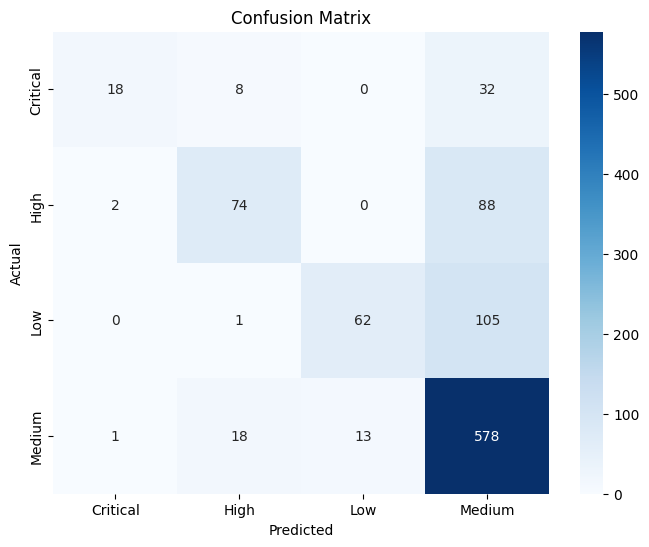

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Severity Distribution in the Dataset

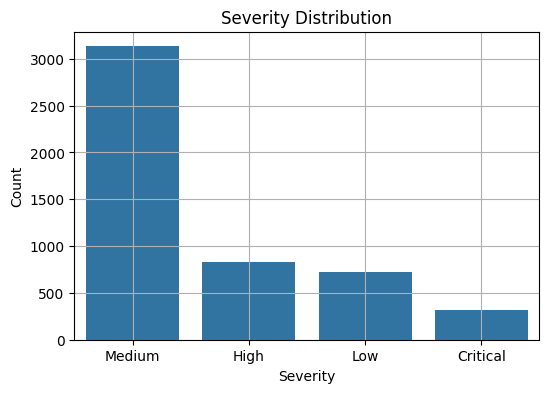

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='severity', data=df, order=df['severity'].value_counts().index)
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.grid(True)
plt.show()


CVSS Score Distribution

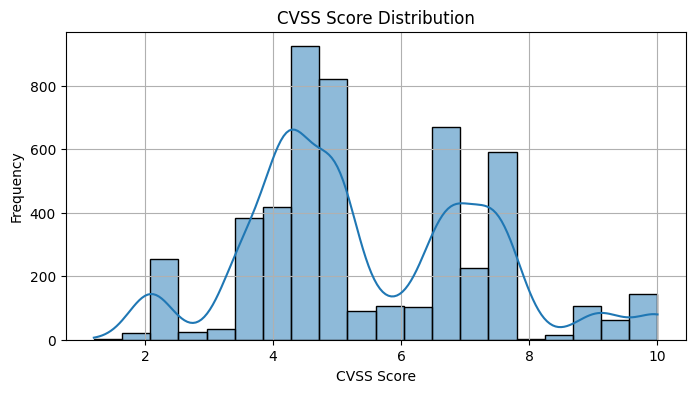

In [6]:
plt.figure(figsize=(8, 4))
sns.histplot(df['cvss_score'].astype(float), bins=20, kde=True)
plt.title('CVSS Score Distribution')
plt.xlabel('CVSS Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


 Learning Curve

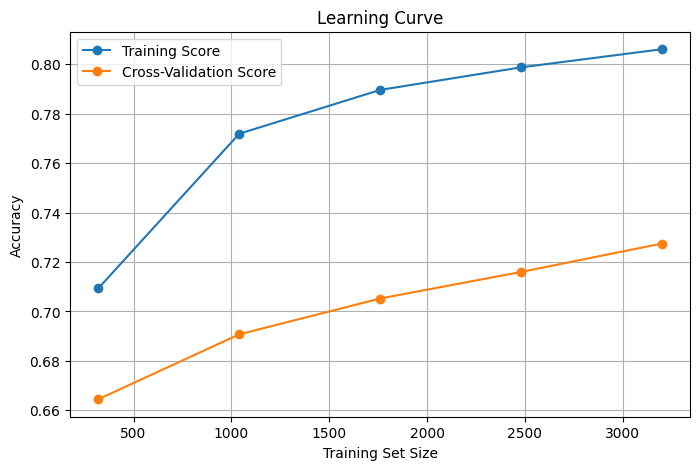

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train_vec, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
